# XGBoost - eXtreme Gradient Boosting

## ICA online sales prediction

In [1]:
import xgboost
import numpy as np
import pandas as pd
from pandas import concat
from pandas import DataFrame
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV

In [2]:
# Loading the dataset as a dataframe
def read_data(start=None, stop=None, columns=None):
    df = pd.read_pickle("ica_summary.pkl")
    tf = df.loc[start:stop, columns]
    return pd.DataFrame(tf)

In [3]:
df = read_data(stop='2021-02-14', columns=['artiklar']) 

### Transform timeseries to a supervised problem

In [4]:
# Creating multiple article columns with seven different shifts
ts = concat([df, df.artiklar.shift(1),df.artiklar.shift(2),df.artiklar.shift(3),df.artiklar.shift(4),df.artiklar.shift(5),df.artiklar.shift(6), df.artiklar.shift(7)], axis=1)

ts.dropna(inplace=True)

In [31]:
# Here is the shifted dataset, where the previous day's value becomes the next day's
ts.tail(10)

,artiklar,artiklar,artiklar,artiklar,artiklar,artiklar,artiklar,artiklar
2021-02-05,4341.0,3364.0,2891.0,1994.0,1641.0,0.0,256.0,5582.0
2021-02-06,1076.0,4341.0,3364.0,2891.0,1994.0,1641.0,0.0,256.0
2021-02-07,0.0,1076.0,4341.0,3364.0,2891.0,1994.0,1641.0,0.0
2021-02-08,1477.0,0.0,1076.0,4341.0,3364.0,2891.0,1994.0,1641.0
2021-02-09,2037.0,1477.0,0.0,1076.0,4341.0,3364.0,2891.0,1994.0
2021-02-10,2508.0,2037.0,1477.0,0.0,1076.0,4341.0,3364.0,2891.0
2021-02-11,4287.0,2508.0,2037.0,1477.0,0.0,1076.0,4341.0,3364.0
2021-02-12,5162.0,4287.0,2508.0,2037.0,1477.0,0.0,1076.0,4341.0
2021-02-13,1083.0,5162.0,4287.0,2508.0,2037.0,1477.0,0.0,1076.0
2021-02-14,0.0,1083.0,5162.0,4287.0,2508.0,2037.0,1477.0,0.0


### Splitting data into train and test

In [5]:
# The first part of the dataset goes to the training data, and the last part selected by pred_days goes to the test data 
def train_test_split(data, pred_days):
    data = data.values
    return data[:-pred_days], data[-pred_days:]

In [6]:
train, test = train_test_split(ts, 7)

In [7]:
X, y = train[:, 1:], train[:, 0]

### Hyperparameter optimization

In [8]:
# Setting up the range of params for the hyperparametertest
params = {
    'n_estimators'     : [500, 1000, 1500, 2000, 2500],
    'learning_rate'    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30], 
    'subsample'        : [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
    'max_depth'        : [3, 4, 5, 6, 8, 10, 12, 15],
    'min_child_weight' : [1, 3, 5, 7],
    'gamma'            : [0.0, 0.1, 0.2, 0.3, 0.4],
    'colsample_bytree' : [0.3, 0.4, 0.5, 0.7, 0.8, 0.9]
}

In [9]:
# Walking trough the defined hyperparameters in params 5 times and gives the 5 best candidates  
random_search=RandomizedSearchCV(model, param_distributions=params, n_iter=5, scoring='roc_auc', n_jobs=-1, cv=5, verbose=3)
random_search.fit(X, y)

NameError: name 'model' is not defined

In [61]:
# Finding the best performing model 
random_search.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0.4, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=5,
             min_child_weight=3, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.5,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [24]:
# Defining the model with the optimal parameters
model = XGBRegressor(colsample_bytree=0.9, gamma=0.3, 
                    learning_rate=0.025, max_depth=10,
                    min_child_weight=3,
                    n_estimators=2059, subsample=0.3, 
                    base_score=0.4, num_parallel_tree=2,
                    random_state=6, reg_alpha=10)

### Make prediction

In [25]:
# Fitting the model and making a one step prediction
def xgb_predict(train, val):
    train = np.array(train)
    X, y = train[:,1:], train[:, 0]
    model.fit(X, y)
    
    val = np.array(val).reshape(1, -1)
    pred = model.predict(val)
    return pred[0]

### Walk-forward validation

In [26]:
from sklearn.metrics import mean_squared_error

# Making a walk-forward validation of the data
def validate(data, test):
    predictions = []
    
    history = [x for x in train]
    
    test_X, test_y = test[:,1:], test[:, 0]
    
    for i in range(len(test)):
        
        pred = xgb_predict(history, test_X[i])
        predictions.append(pred)
        
        history.append(test[i])
        print('>predicted=%.1f' % (pred))      
        
    error = mean_squared_error(test[:, 0], predictions, squared=False)
    
    return error, test[:, 0], predictions

In [27]:
%%time
mae, y, pred = validate(ts, test)

print('MAE: %.3f' % mae)

/Users/emelieandersson/PycharmProject/Jupyter/venv/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


>predicted=1807.7
>predicted=2375.0
>predicted=2510.6
>predicted=4250.9
>predicted=4861.9
>predicted=1274.4
>predicted=134.5
MAE: 229.811
CPU times: user 1min 3s, sys: 1.78 s, total: 1min 4s
Wall time: 26.7 s


In [28]:
from sklearn.metrics import r2_score
r2_score(y, pred) 

0.9812058437995208

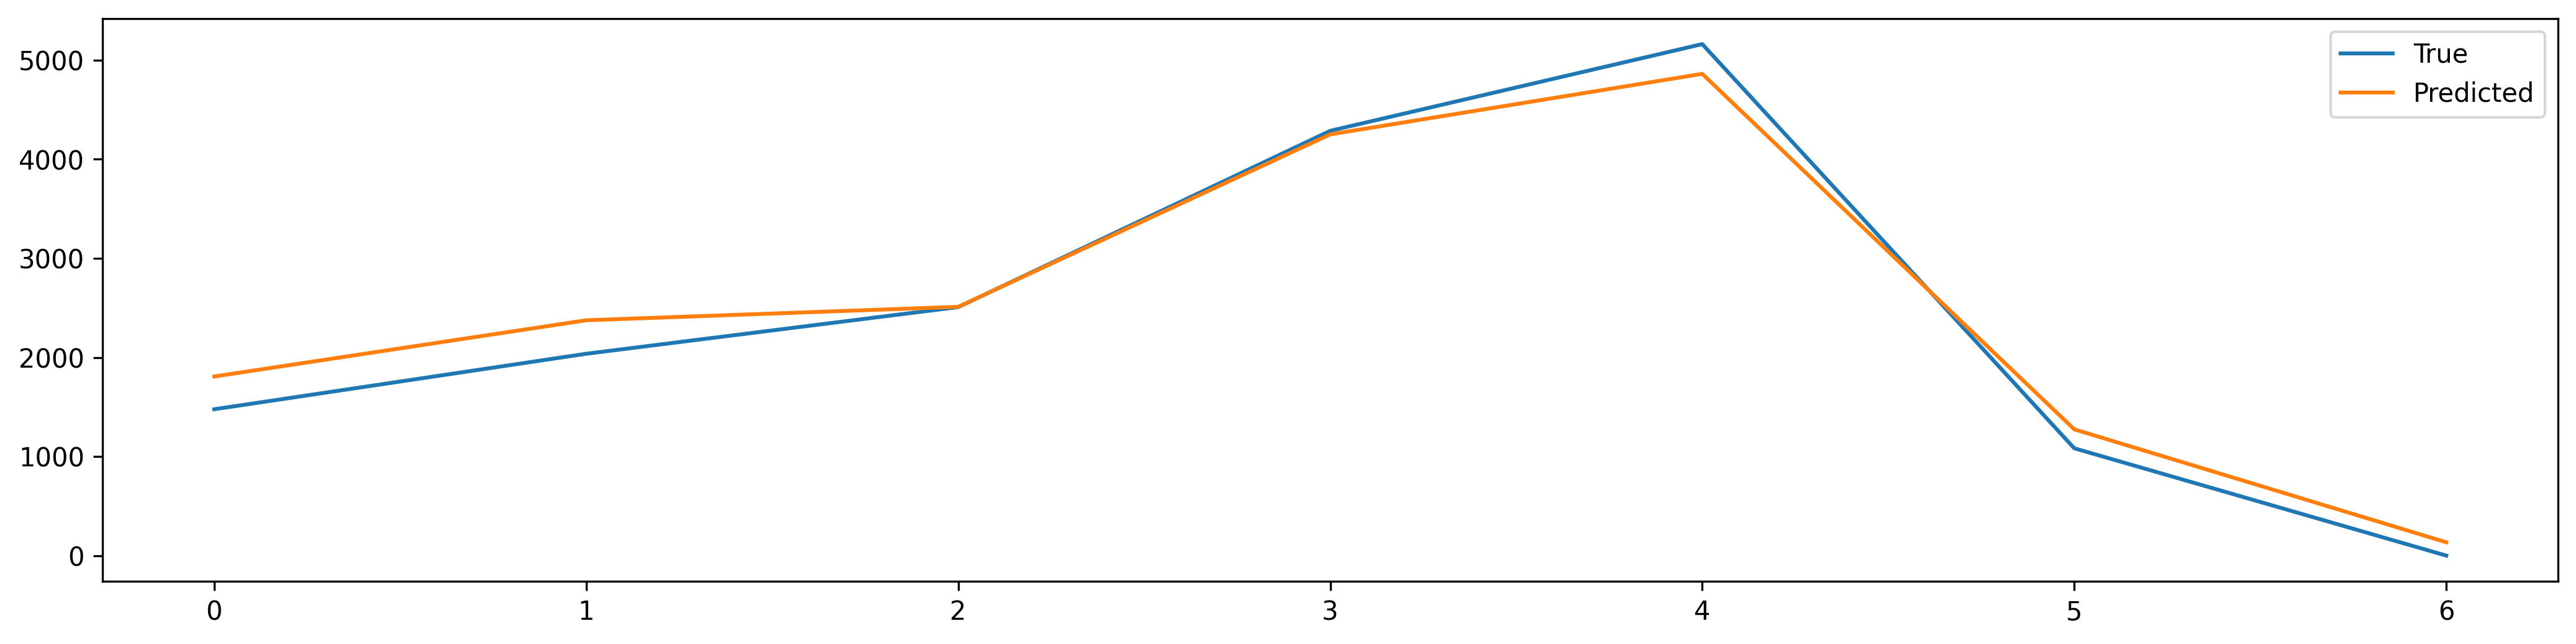

In [29]:
plt.rcParams.update({'figure.figsize': (17, 4), 'figure.dpi': 300})
fig, ax = plt.subplots()
plt.plot(y, label='True')
plt.plot(pred, label='Predicted')
plt.legend()

<AxesSubplot:>

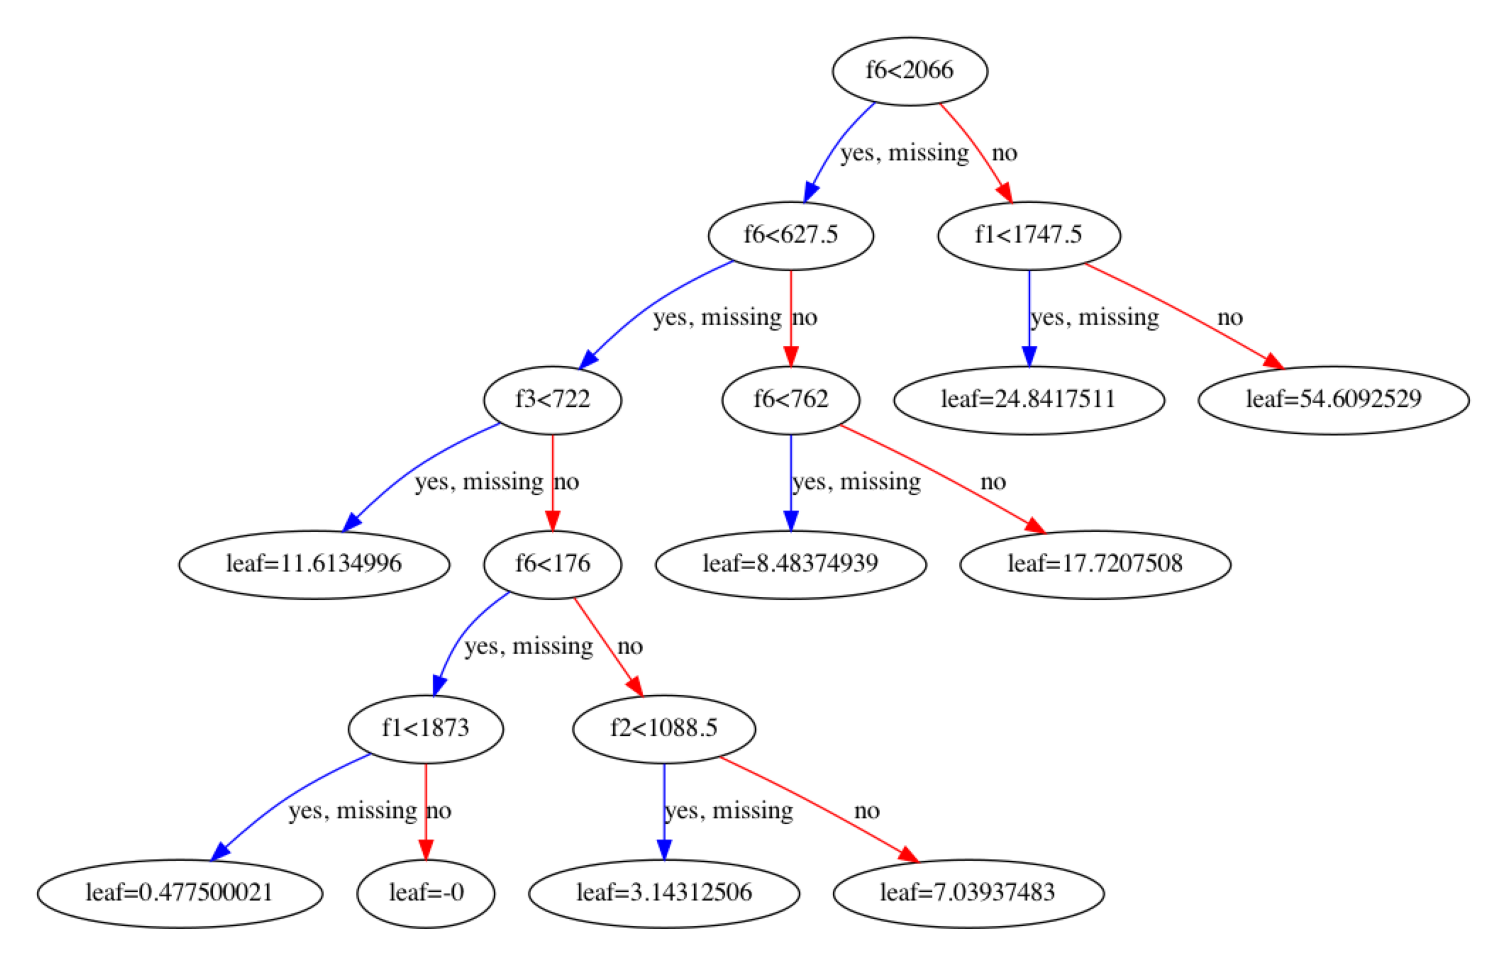

In [30]:
from xgboost import plot_tree
plot_tree(model)

## **Ending notes**  

* **Positives**
    * An effective model which gives good predicting results fast. 
    * Quick and easy to use and comprehend, making it suitable to use for a first time project.
    * Many diffrent hyperparameters and fine tuning possibilities.
    * Generally fast to set up and train.
    

* **Negatives**
    * Takes not exogenous variables as standard. 
    * Produces quite unstable results with a small dataset. 
    * Lots of diffrent settings, hard to know which ones has an impact and when to stop modifiying the model.
    * Slow to train if using many trees.